# Project Summary
## Description
Analysis of spending behavior of discretionary income in the US.
Discretionary income is the income remaining to spend on nonessential items.

## Analysis Questions
### How is the overall discretionary income in the US spent?
Across all consumer units, approximately half of discretionary income is spent on food away and entertainment. The next highest nonessential spending is in cash contributions.
![Chart](Images/discretionary_spend.png)

### How is the overall essential income in the US spent?
After taxes, consumers spend the most money on housing expenses, which is more than half of the other 3 categories (health, food at home, and transportation). Transportation is the 2nd largest category of essential spending with food at home and healthcare expenses being about the same. 
![Chart](Images/essential_spend.png)

### How does age group impact the spread of discretionary spending?
The data suggests that some of the most noticeable trends are that cash contributions increase as age groups increase. This is a direct correlation. Inversely, expenditure on education follows a decreasing trend across the age groups with the exception of age group 45-54 where this age group has a dramatic increase in education expenditure compared to the other age groups besides Under 25.  
![Chart](Images/spend_by_age.png)

### How does geographic region in the US impact the spread of discretionary spending?
Overall, the data suggests the highest percentage of discretionary spending was on the personal care and education categories. The data doesn't suggest any significant changes across geographic regions.
![Chart](Images/spend_by_geo.png)

### How does education level impact the spread of discretionary spending?
The data suggests tobacco and alcohol usage decreases from consumers who have less than a High School degree towards consumer who have acquired more professional degrees. The opposite trend is seen with cash contributions. The other categories are consistent across educational levels
![Chart](Images/spend_by_education.png)

### How does race impact the spread of discretionary spending?
BLS breaks race into three categories - Black or African-American, Asian, and White and All Other. The data suggests the following differences across race groups:
1. The Asian race group spends the highest percentage in education expenditure and the lowest percentage in cash contributions compared to the other race groups.
2. White and other race groups spend the highest percentage in entertainment and the lowerst percentage in apparel expenditure compared to the other race groups.
3. Black or African-American race groups spend the highest percentage in apparel when compared to the other race groups.
![Chart](Images/spend_by_race.png)

### Based on previous economic recessions, how might consumer expenditure adjust in recovering from the coronavirus shut downs?
Based on 2009 data following the 2008 recession, discretionary spending decreased in every category except education and tobacco. The greatest percent increase in spending was observed in tabacco products. The greatest percent decrease in spending was observed in entertainment and apparel. Considering the the indefinite pause on many entertainment events or services caused but the pandemic, a significant decrease in entertainment is likely to be observed again.
![Chart](Images/2009_percent_change.png)

In [1]:
# Importing dependecies
import pandas as pd
import json
import requests
from config import api_key
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Dictionary of series ID 
discretionary_dict = {
    'CXUFOODAWAYLB1101M': 'Food away from home',
    'CXUAPPARELLB1101M': 'Apparel and services',
    'CXUENTRTAINLB1101M': 'Entertainment',
    'CXUCASHCONTLB1101M': 'Cash contributions',
    'CXUALCBEVGLB1101M': 'Alcoholic beverages',
    'CXUEDUCATNLB1101M': 'Education',
    'CXUPERSCARELB1101M': 'Personal care products and services',
    'CXUTOBACCOLB1101M': 'Tobacco products and smoking supplies'
}

essential_dict = {
     'CXUFOODHOMELB0401M': 'Food at home',
     'CXUHEALTHLB0401M': 'Healthcare',
     'CXUHOUSINGLB0401M': 'Housing',
     'CXUTRANSLB0401M': 'Transportion', 
}

In [3]:
# Description: Load the json response for the API queries
# Input: dictionary of seriesID - name key-value pairs
# Output: DataFrame to orgnanize the API query response
def json_df(dictionary):
    headers = {'Content-type': 'application/json'}
    data = json.dumps({"seriesid": list(dictionary.keys()),"startyear":"2005", "endyear":"2018","registrationkey":api_key})
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text)

    try:
        df = pd.DataFrame()

        # Loops through the json response to create a DataFrame
        for series in json_data['Results']['series']:
            # Create an initial DataFrame with column of Series IDs and dictionary of data
            df_initial = pd.DataFrame(series)
            series_col = df_initial['seriesID'][0]

            # Loops through the length of the initial DF to split up its second column
            for i in range(0, len(df_initial) - 1):
                df_row = pd.DataFrame(df_initial['data'][i])
                df_row['seriesID'] = series_col
                if 'code' not in str(df_row['footnotes']): 
                    df_row['footnotes'] = ''
                else:
                    df_row['footnotes'] = str(df_row['footnotes']).split("'code': '",1)[1][:1]
                df = df.append(df_row, ignore_index=True)

    except:
        json_data['status'] == 'REQUEST_NOT_PROCESSED'
        print('BLS API has given the following Response:', json_data['status'])
        print('Reason:', json_data['message'])
    return df

In [4]:
# Description: Computers the total of each series ID 
# Input: DataFrame created by calling json_df()
# Output: List of totals for each series ID
def get_total(df):
    # Initialize variables
    total = []
    dict_list = []
    i = 0
    
    # Convert the value column to float - a numeric data type will be needed to visualize the data
    df['value'] = df['value'].astype(float)
    
    series_set = set(df["seriesID"])
    for e in series_set:
        dict_list.append(e)
    
    dict_list = sorted(dict_list)
    
    # Loop through series list to create a list of the totals of each spending category
    for key in dict_list:
        # Append a value to a list to record the spending for each category
        total.append(int(df.groupby('seriesID')['value'].sum()[key]))

        # Counter
        i = i + 1
    return total

In [5]:
# Get the DataFrame for the discretionary expenditure series ID for all consumer units
df_discretionary = json_df(discretionary_dict)

# Get the total discretionary expenditure for each category 
total_discretionary = get_total(df_discretionary)

df_discretionary.head()

,year,period,periodName,latest,value,footnotes,seriesID
0,2018,A01,Annual,true,3459.0,,CXUFOODAWAYLB1101M
1,2017,A01,Annual,NaN,3365.0,,CXUFOODAWAYLB1101M
2,2016,A01,Annual,NaN,3154.0,,CXUFOODAWAYLB1101M
3,2015,A01,Annual,NaN,3008.0,,CXUFOODAWAYLB1101M
4,2014,A01,Annual,NaN,2787.0,,CXUFOODAWAYLB1101M


In [6]:
# Get the DataFrame for the essential expenditure series ID for all consumer units
df_essential = json_df(essential_dict)

# Get the total essential expenditure for each category 
total_essential = get_total(df_essential)

df_essential.head()

,year,period,periodName,latest,value,footnotes,seriesID
0,2018,A01,Annual,true,4464.0,,CXUFOODHOMELB0401M
1,2017,A01,Annual,NaN,4363.0,,CXUFOODHOMELB0401M
2,2016,A01,Annual,NaN,4049.0,,CXUFOODHOMELB0401M
3,2015,A01,Annual,NaN,4015.0,,CXUFOODHOMELB0401M
4,2014,A01,Annual,NaN,3971.0,,CXUFOODHOMELB0401M


## Discretionary Spending Pie Chart (All Consumer Units)

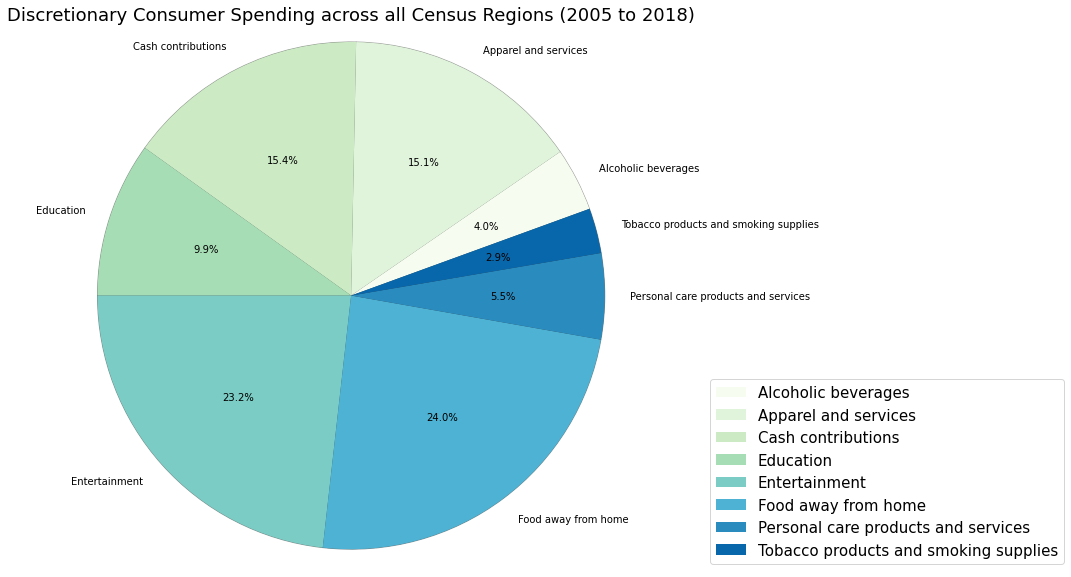

In [7]:
# Labels of the categories
discretionary_labels = sorted(list(discretionary_dict.values()))

# Don't explode any slice of the pie
explode = (0, 0, 0, 0, 0, 0, 0, 0)  

# Initialize figure and axis
fig1, ax1 = plt.subplots(figsize=(10,10))

# Create pie chart of the breakdown of discretionary spending
theme = plt.get_cmap("GnBu") #CHANGE THIS TO EDIT COLORS. SEE CMAP COLOR FORMATS, https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
ax1.set_prop_cycle("color", [theme(1. * i / len(total_discretionary)) 
                             for i in range(len(total_discretionary))])
       
ax1.pie(total_discretionary, explode=explode, labels=discretionary_labels, autopct='%1.1f%%',
        shadow=True, startangle=20, radius=1800)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.rcParams['font.size'] = 15

plt.legend(
    loc='upper left',
    labels = discretionary_labels,
    bbox_to_anchor=(1, 0.4),
    bbox_transform=fig1.transFigure
)
plt.title('Discretionary Consumer Spending across all Census Regions (2005 to 2018)')
plt.xlabel('')
plt.ylabel('')

# Save figure
plt.savefig('Images/discretionary_spend.png',bbox_inches="tight")
plt.show()

## Essential Spending Pie Chart (All Consumer Units)

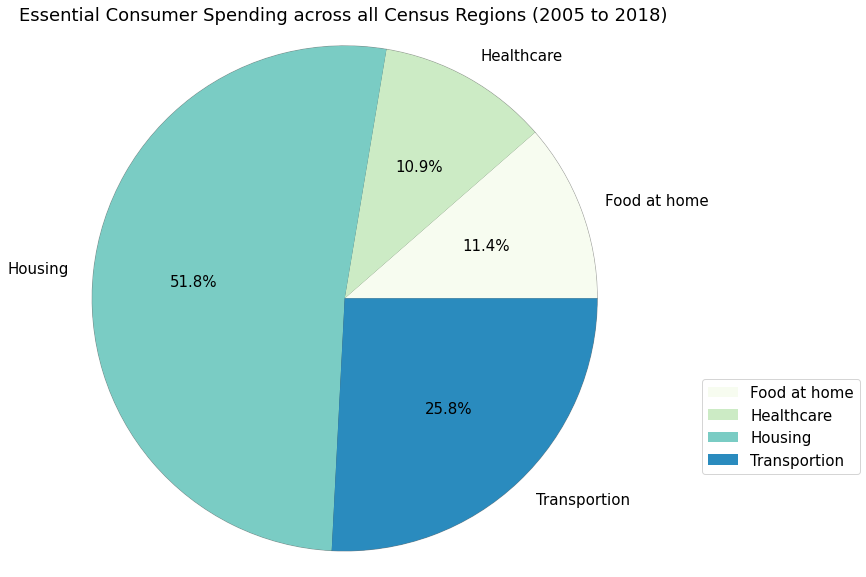

In [8]:
# Labels of the categories
essential_labels = sorted(list(essential_dict.values()))

# Don't explode any slice of the pie
explode = (0, 0, 0, 0)  

# Initialize figure and axis
fig1, ax1 = plt.subplots(figsize=(10,10))

# Create pie chart of the breakdown of discretionary spending
theme = plt.get_cmap("GnBu") #CHANGE THIS TO EDIT COLORS. SEE CMAP COLOR FORMATS, https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
ax1.set_prop_cycle("color", [theme(1. * i / len(total_essential))
                             for i in range(len(total_essential))])
       
ax1.pie(total_essential, explode=explode, labels=essential_labels, autopct='%1.1f%%',
        shadow=True, startangle=0, radius=1800)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.rcParams['font.size'] = 15

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1, 0.4),
    bbox_transform=fig1.transFigure
)

plt.title('Essential Consumer Spending across all Census Regions (2005 to 2018)')
plt.xlabel('')
plt.ylabel('')

# Save figure
plt.savefig('Images/essential_spend.png',bbox_inches="tight")
plt.show()

## 2009 Discretionary Spending Percent Change Analysis (Post Recession)

In [9]:
# Sort data by series ID and year
df_discretionary = df_discretionary.sort_values(['seriesID','year'], ascending = True).reset_index(drop=True)
df_discretionary

,year,period,periodName,latest,value,footnotes,seriesID
0,2006,A01,Annual,NaN,497.0,,CXUALCBEVGLB1101M
1,2007,A01,Annual,NaN,457.0,,CXUALCBEVGLB1101M
2,2008,A01,Annual,NaN,444.0,,CXUALCBEVGLB1101M
3,2009,A01,Annual,NaN,435.0,,CXUALCBEVGLB1101M
4,2010,A01,Annual,NaN,412.0,,CXUALCBEVGLB1101M
...,...,...,...,...,...,...,...
99,2014,A01,Annual,NaN,319.0,,CXUTOBACCOLB1101M
100,2015,A01,Annual,NaN,349.0,,CXUTOBACCOLB1101M
101,2016,A01,Annual,NaN,337.0,,CXUTOBACCOLB1101M
102,2017,A01,Annual,NaN,332.0,,CXUTOBACCOLB1101M


In [10]:
# Get percent change over the years, grouped by series ID
df_discretionary['pct_decimal'] = df_discretionary.groupby(['seriesID'])['value'].pct_change()
df_discretionary['percent_change'] = df_discretionary['pct_decimal'].multiply(100)
df_discretionary

,year,period,periodName,latest,value,footnotes,seriesID,pct_decimal,percent_change
0,2006,A01,Annual,NaN,497.0,,CXUALCBEVGLB1101M,NaN,NaN
1,2007,A01,Annual,NaN,457.0,,CXUALCBEVGLB1101M,-0.080483,-8.048290
2,2008,A01,Annual,NaN,444.0,,CXUALCBEVGLB1101M,-0.028446,-2.844639
3,2009,A01,Annual,NaN,435.0,,CXUALCBEVGLB1101M,-0.020270,-2.027027
4,2010,A01,Annual,NaN,412.0,,CXUALCBEVGLB1101M,-0.052874,-5.287356
...,...,...,...,...,...,...,...,...,...
99,2014,A01,Annual,NaN,319.0,,CXUTOBACCOLB1101M,-0.033333,-3.333333
100,2015,A01,Annual,NaN,349.0,,CXUTOBACCOLB1101M,0.094044,9.404389
101,2016,A01,Annual,NaN,337.0,,CXUTOBACCOLB1101M,-0.034384,-3.438395
102,2017,A01,Annual,NaN,332.0,,CXUTOBACCOLB1101M,-0.014837,-1.483680


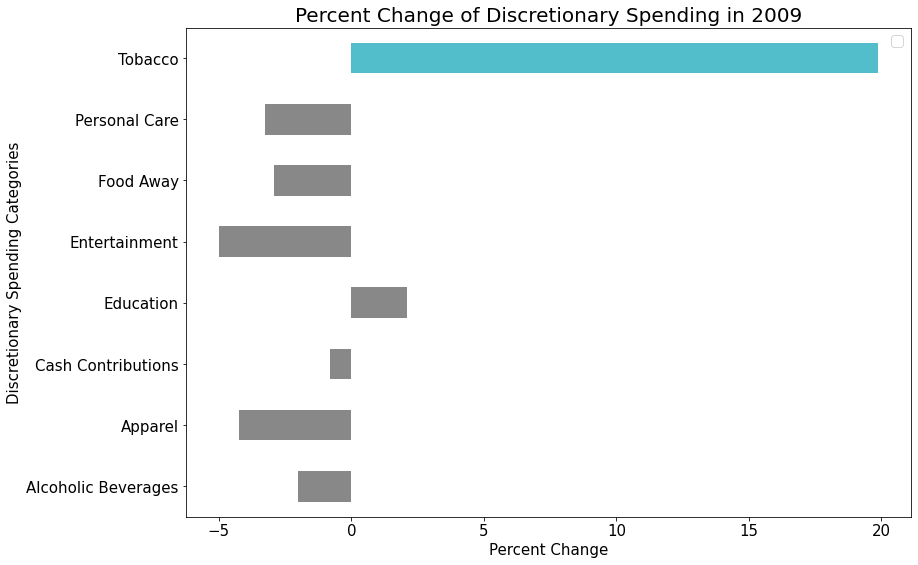

In [11]:
# Example python program to plot a horizontal bar chart
percent_chg_2009 = df_discretionary.loc[df_discretionary.year == '2009'][['seriesID','percent_change']]

dataFrame  = pd.DataFrame(data = percent_chg_2009)
colors = ["#888888","#888888","#888888","#888888","#888888","#888888","#888888","#52becc"]
dataFrame.plot.barh(x='seriesID', 
                    y='percent_change', 
                    color=colors, figsize=(13,9))

plt.yticks(np.arange(8), ("Alcoholic Beverages", 
                          "Apparel", 
                          "Cash Contributions", 
                          "Education", 
                          "Entertainment", 
                          "Food Away", 
                          "Personal Care", 
                          "Tobacco"))

plt.title("Percent Change of Discretionary Spending in 2009",fontsize=20)
plt.xlabel('Percent Change')
plt.ylabel('Discretionary Spending Categories')
plt.legend('')

# Save figure
plt.savefig('Images/2009_percent_change.png',bbox_inches="tight")
plt.show(block=True)

## Demographic Analysis
### Age Groups
Calling API Query to get discretionary spending based on age demographics

In [12]:
# Age 25-34 Characteristic Code: LB0402M
age25_dict = {
    'CXUFOODAWAYLB0402M': 'Food Away Under 25',
    'CXUAPPARELLB0402M': 'Apparel Under 25',
    'CXUENTRTAINLB0402M': 'Entertainment Under 25',
    'CXUCASHCONTLB0402M': 'Cash Contribution Under 25',
    'CXUALCBEVGLB0402M': 'Alcohol Under 25',
    'CXUEDUCATNLB0402M': 'Education Under 25',
    'CXUPERSCARELB0402M': 'Personal Care Under 25',
    'CXUTOBACCOLB0402M': 'Tobacco Under 25',
}
df_age25 = json_df(age25_dict) # Age under 25 DataFrame

# Age 25-34 Characteristic Code: LB0403M
age2534_dict = {
    'CXUFOODAWAYLB0403M': 'Food Away 25 to 34',
    'CXUAPPARELLB0403M': 'Apparel 25 to 34',
    'CXUENTRTAINLB0403M': 'Entertainment 25 to 34',
    'CXUCASHCONTLB0403M': 'Cash Contribution 25 to 34',
    'CXUALCBEVGLB0403M': 'Alcohol 25 to 34',
    'CXUEDUCATNLB0403M': 'Education 25 to 34',
    'CXUPERSCARELB0403M': 'Personal Care 25 to 34',
    'CXUTOBACCOLB0403M': 'Tobacco 25 to 34',  
}
df_age2534 = json_df(age2534_dict) # Age from 25 to 34 DataFrame

# Age 35-44 Characteristic Code: LB0404M
age3544_dict = {
    'CXUFOODAWAYLB0404M': 'Food Away 35 to 44',
    'CXUAPPARELLB0404M': 'Apparel 35 to 44',
    'CXUENTRTAINLB0404M': 'Entertainment 35 to 44',
    'CXUCASHCONTLB0404M': 'Cash Conttribution 35 to 44',
    'CXUALCBEVGLB0404M': 'Alcohol 35 to 44',
    'CXUEDUCATNLB0404M': 'Education 35 to 44',
    'CXUPERSCARELB0404M': 'Personal Care 35 to 44',
    'CXUTOBACCOLB0404M': 'Tobacco 35 to 44',
}
df_age3544 = json_df(age3544_dict) # Age from 35 to 44 DataFrame

# Age 45-54 Characteristic Code: LB0405M
age4554_dict = {
    'CXUFOODAWAYLB0405M': 'Food Away 45 to 54',
    'CXUAPPARELLB0405M': 'Apparel 45 to 54',
    'CXUENTRTAINLB0405M': 'Entertainment 45 to 54',
    'CXUCASHCONTLB0405M': 'Cash Contribution 45 to 54',
    'CXUALCBEVGLB0405M': 'Alcohol 45 to 54',
    'CXUEDUCATNLB0405M': 'Education 45 to 54',
    'CXUPERSCARELB0405M': 'Personal Care 45 to 54',
    'CXUTOBACCOLB0405M': 'Tobacco 45 to 54',
}
df_age4554 = json_df(age4554_dict) # Age from 45 to 54 DataFrame


# Age 55-64 Characteristic Code: LB0406M
age5564_dict = {
    'CXUFOODAWAYLB0406M': 'Food Away 55 to 64',
    'CXUAPPARELLB0406M': 'Apparel 55 to 64',
    'CXUENTRTAINLB0406M': 'Entertainment 55 to 64',
    'CXUCASHCONTLB0406M': 'Cash Contribution 55 to 64',
    'CXUALCBEVGLB0406M': 'Alcohol 55 to 64',
    'CXUEDUCATNLB0406M': 'Education 55 to 64',
    'CXUPERSCARELB0406M': 'Personal Care 55 to 64',
    'CXUTOBACCOLB0406MM': 'Tobacco 55 to 64',
}
df_age5564 = json_df(age5564_dict) # Age from 55 to 64 DataFrame

#Age Over 65 Characteristic Code: LB0407
age65_dict = {
    'CXUFOODAWAYLB0407M': 'Food Away Over 65',
    'CXUAPPARELLB0407M': 'Apparel Over 65',
    'CXUENTRTAINLB0407M': 'Entertainment Over 65',
    'CXUCASHCONTLB0407M': 'Cash Contribution Over 65',
    'CXUALCBEVGLB0407M': 'Alcohol Over 65',
    'CXUEDUCATNLB0407M': 'Education Over 65',
    'CXUPERSCARELB0407M': 'Personal Care Over 65',
    'CXUTOBACCOLB0407M': 'Tobacco Over 65',
}
df_age65 = json_df(age65_dict) # Age over 65 DataFrame

BLS API has given the following Response: REQUEST_SUCCEEDED
Reason: ['Series does not exist for Series CXUTOBACCOLB0406MM']


In [13]:
# Set list for each Age Group to store totals for each category (alphabetized)

# Grab Values for Age Groups
AgeUnder25 = get_total(df_age25)
Age25to34 = get_total(df_age2534)
Age35to44 = get_total(df_age3544)
Age45to54 = get_total(df_age4554)
Age55to64 = get_total(df_age5564)
Age64plus = get_total(df_age65)

age_totals = [AgeUnder25, Age25to34, Age35to44, Age45to54, Age55to64, Age64plus]
# No data for Tobacco for age groups 55 to 64

# AGE GROUP DF
age_name=['Under 25', '25 to 34', '35 to 44', '45 to 54', '55 to 64', "Over 65"]
age_df = pd.DataFrame(data=age_totals,
                      columns=discretionary_labels)
age_df["Age Group"] = age_name
age_df.set_index("Age Group", drop=True, inplace=True)
age_df

,Alcoholic beverages,Apparel and services,Cash contributions,Education,Entertainment,Food away from home,Personal care products and services,Tobacco products and smoking supplies
Age Group,,,,,,,,
Under 25,4654,17669,5793,27749,17727,26746,4836,3413.0
25 to 34,6999,25780,13199,12545,31887,38273,7426,4325.0
35 to 44,6952,29915,20530,13129,43257,45920,9749,4745.0
45 to 54,6982,28108,27481,29278,42955,44716,9961,5724.0
55 to 64,6624,22071,29545,14275,38840,35997,8759,NaN
Over 65,4356,13898,31218,3541,28299,25184,7430,2579.0


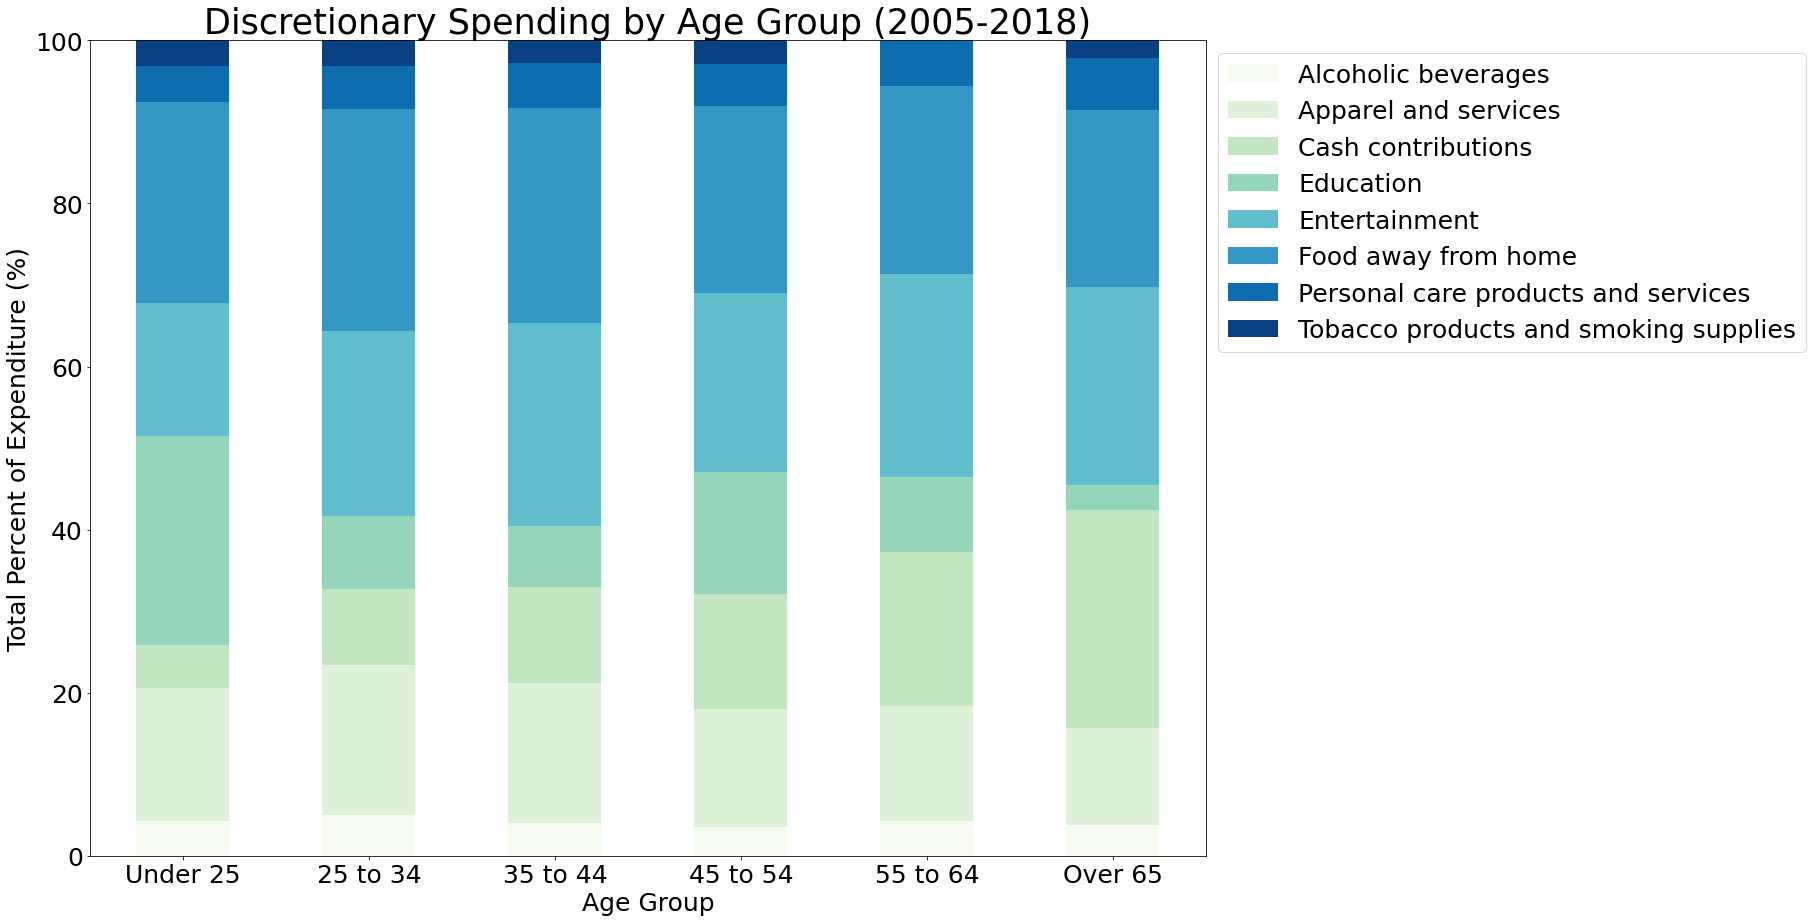

In [14]:
# Create stacked bar chart

# Compute the percentage 
age_df = age_df.div(age_df.sum(axis=1), axis=0) * 100

# Plot a stacked barchart
tocolor = (discretionary_labels)
colors = plt.get_cmap("GnBu", len(tocolor)) #CHANGE THIS TO EDIT COLORS. SEE CMAP COLOR FORMATS, https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
ax = age_df.plot.bar(stacked=True, figsize=(20,15), fontsize=25, colormap=colors)

# Place the legend
ax.legend(bbox_to_anchor=(1, 1), fontsize=25)
plt.xticks(rotation=0)
plt.ylim(0, 100) 
plt.title('Discretionary Spending by Age Group (2005-2018)', fontsize=35)
plt.xlabel('Age Group', fontsize=25)
plt.ylabel('Total Percent of Expenditure (%)', fontsize=25)

# Save figure
plt.savefig('Images/spend_by_age.png',bbox_inches="tight")
plt.show()

### Geographic Regions
Calling API Query to get discretionary spending based on geographic region demographic

In [15]:
# Northeast Characteristic Code: LB1102M

ne_dict = {
    'CXUFOODAWAYLB1102M': 'Northeast Food Away',
    'CXUAPPARELLB1102M': 'Northeast Apparel',
    'CXUENTRTAINLB1102M': 'Northeast Entertainment',
    'CXUCASHCONTLB1102M': 'Northeast Cash Contribution',
    'CXUALCBEVGLB1102M': 'Northeast Alcohol Beverages',
    'CXUEDUCATNLB1102M': 'Northeast Education',
    'CXUPERSCARELB1102M': 'Northeast Personal Care',
    'CXUTOBACCOLB1102M': 'Northeast Tobacco'
}

ne_df = json_df(ne_dict) # Northeast DataFrame

In [16]:
# Midwest Characteristic Code: LB1103M

mw_dict = {
    'CXUFOODAWAYLB1103M': 'Midwest Food Away',
    'CXUAPPARELLB1103M': 'Midwest Apparel',
    'CXUENTRTAINLB1103M': 'Midwest Entertainment',
    'CXUCASHCONTLB1103M': 'Midwest Cash Contribution',
    'CXUALCBEVGLB1103M': 'Midwest Alcohol Beverages',
    'CXUEDUCATNLB1103M': 'Midwest Education',
    'CXUPERSCARELB1103M': 'Midwest Personal Care',
    'CXUTOBACCOLB1103M': 'Midwest Tobacco'
}

mw_df = json_df(mw_dict) # Midwest DataFrame

In [17]:
# Southern Characteristic Code: LB1104M

south_dict = {
    'CXUFOODAWAYLB1104M': 'Southern Food Away',
    'CXUAPPARELLB1104M': 'Southern Apparel',
    'CXUENTRTAINLB1104M': 'Southern Entertainment',
    'CXUCASHCONTLB1104M': 'Southern Cash Contribution',
    'CXUALCBEVGLB1104M': 'Southern Alcohol Beverages',
    'CXUEDUCATNLB1104M': 'Southern Education',
    'CXUPERSCARELB1104M': 'Southern Personal Care',
    'CXUTOBACCOLB1104M': 'Southern Tobacco'
}

south_df = json_df(south_dict) # Southern DataFrame

In [18]:
# Western Characteristic Code: LB1105M
west_dict = {
    'CXUFOODAWAYLB1105M': 'Western Food Away',
    'CXUAPPARELLB1105M': 'Western Apparel',
    'CXUENTRTAINLB1105M': 'Western Entertainment',
    'CXUCASHCONTLB1105M': 'Western Cash Contribution',
    'CXUALCBEVGLB1105M': 'Western Alcohol Beverages',
    'CXUEDUCATNLB1105M': 'Western Education',
    'CXUPERSCARELB1105M': 'Western Personal Care',
    'CXUTOBACCOLB1105M': 'Western Tobacco'
}

west_df = json_df(west_dict) # Western DataFrame

In [19]:
# Set list for each Geo Group to store totals for each category

# Grab Values for Geo Groups
Northeast = get_total(ne_df) # Northeast totals
Midwest = get_total(mw_df) # Midwest totals
South = get_total(south_df) # Southern totals
West = get_total(west_df) # Western

geo_totals = [Northeast, Midwest, South, West]
# No data for Tobacco for age groups 55 to 64

# AGE GROUP DF
geo_name = ['Northeast', 'Midwest', 'South', 'West']
geo_df = pd.DataFrame(data=geo_totals,
                      columns=discretionary_labels)
geo_df["Geo Group"] = geo_name
geo_df.set_index("Geo Group", drop=True, inplace=True)
geo_df

,Alcoholic beverages,Apparel and services,Cash contributions,Education,Entertainment,Food away from home,Personal care products and services,Tobacco products and smoking supplies
Geo Group,,,,,,,,
Northeast,6884,25281,21921,22978,36073,38362,8530,4588
Midwest,6206,21623,23204,15107,35918,34573,7954,4930
South,5078,21521,22420,11229,32133,34610,7923,4644
West,7505,25854,27785,15515,41036,41741,9546,3336


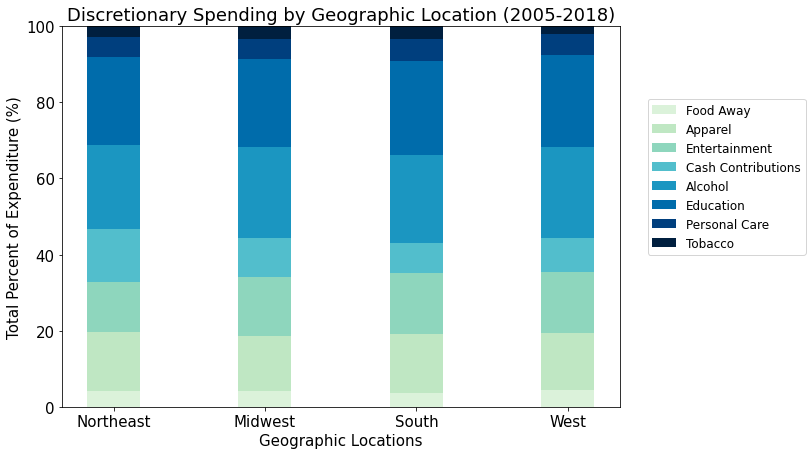

In [20]:
geo_df = geo_df.div(geo_df.sum(axis=1), axis=0) * 100

# Use iloc to grab the data from each of the columns, then label that data

food_away = geo_df.iloc[:,0]
apparel = geo_df.iloc[:,1]
entertainment = geo_df.iloc[:,2]
cash_contributions = geo_df.iloc[:,3]
alcohol_bev = geo_df.iloc[:,4]
education = geo_df.iloc[:,5]
personal_care = geo_df.iloc[:,6]
tobacco = geo_df.iloc[:,7]

# Height needs to match what you're graphing, and last bottom matches the previous line's height
plt.figure(figsize= (10,7))

graphfaway = plt.bar(x=geo_name, height=food_away, width=0.35 , label = 'Food Away', color = "#dbf2da")
graphapparel = plt.bar(x=geo_name, height=apparel, width=0.35, bottom = food_away, label = 'Apparel', color = '#bfe7c3')
graphentertainment = plt.bar(x=geo_name, height=entertainment, width=0.35, bottom = food_away + apparel , label = 'Entertainment', color = '#8ed6bd')
graphcashcont = plt.bar(x=geo_name, height=cash_contributions, width=0.35, bottom = food_away + apparel + entertainment , label = 'Cash Contributions', color = '#52becc')
graphalcohol = plt.bar(x=geo_name, height=alcohol_bev, width=0.35, bottom = food_away + apparel + entertainment + cash_contributions, label = 'Alcohol', color = '#1b96c1')
grapheducation = plt.bar(x=geo_name, height=education, width=0.35, bottom = food_away + apparel + entertainment + cash_contributions + alcohol_bev, label = 'Education', color = '#006cab')
graphperscare = plt.bar(x=geo_name, height=personal_care, width=0.35, bottom = food_away + apparel + entertainment + cash_contributions + alcohol_bev + education, label = 'Personal Care', color = '#003f7e')
graphtobacco = plt.bar(x=geo_name, height=tobacco, width=0.35, bottom = food_away + apparel + entertainment + cash_contributions + alcohol_bev + education + personal_care, label = 'Tobacco', color = '#001F3F' )

plt.xlabel('Geographic Locations')
plt.ylabel('Total Percent of Expenditure (%)')

# Create the ticks
plt.ylim(0, 100) 
plt.title('Discretionary Spending by Geographic Location (2005-2018)')
plt.legend(fontsize = 12, loc = (1.05, 0.4))

# Save figure
plt.savefig('Images/spend_by_geo.png',bbox_inches="tight")
plt.show()

### Race Groups
Calling API Query to get discretionary spending based on race demographics

In [21]:
# 'Black or African-American' Characteristic Code: LB0905M
BAA_dict = {
    'CXUFOODAWAYLB0905M': 'Black or African-American Food Away from Home',
    'CXUAPPARELLB0905M': 'Black or African-American Apparel',
    'CXUENTRTAINLB0905M': 'Black or African-American Entertainment',
    'CXUCASHCONTLB0905M': 'Black or African-American Cash Contribution',
    'CXUALCBEVGLB0905M': 'Black or African-American Alcoholic Beverages',
    'CXUEDUCATNLB0905M': 'Black or African-American Education',
    'CXUPERSCARELB0905M': 'Black or African-American Personal Care',
    'CXUTOBACCOLB0905M': 'Black or African-American Tobacco',
}
df_BAA = json_df(BAA_dict) # 'Black or African-American' DataFrame

# 'Asian' Characteristic Code: LB0904M
ASN_dict = {
    'CXUFOODAWAYLB0904M': 'Asian Food Away from Home',
    'CXUAPPARELLB0904M': 'Asian Apparel',
    'CXUENTRTAINLB0904M': 'Asian Entertainment',
    'CXUCASHCONTLB0904M': 'Asian Cash Contribution',
    'CXUALCBEVGLB0904M': 'Asian Alcoholic Beverages',
    'CXUEDUCATNLB0904M': 'Asian Education',
    'CXUPERSCARELB0904M': 'Asian Personal Care',
    'CXUTOBACCOLB0904M': 'Asian Tobacco',  
}
df_ASN = json_df(ASN_dict) # 'Asian' DataFrame

# 'White and All Other Races' Characteristic Code: LB0903M
WAO_dict = {
    'CXUFOODAWAYLB0903M': 'White and Other Races Food Away from Home',
    'CXUAPPARELLB0903M': 'White and Other Races Apparel',
    'CXUENTRTAINLB0903M': 'White and Other Races Entertainment',
    'CXUCASHCONTLB0903M': 'White and Other Races Cash Conttribution',
    'CXUALCBEVGLB0903M': 'White and Other Races White and Other Races Alcoholic Beverages',
    'CXUEDUCATNLB0903M': 'White and Other Races Education',
    'CXUPERSCARELB0903M': 'White and Other Races Personal Care',
    'CXUTOBACCOLB0903M': 'White and Other Races Tobacco',
}
df_WAO = json_df(WAO_dict) # 'White and All Other Races' DataFrame

In [22]:
# Set list for each Age Group to store totals for each category (alphabetized)

# Grab Values for Age Groups
Black_AA = get_total(df_BAA)
Asian = get_total(df_ASN)
White_Others = get_total(df_WAO)

race_totals = [Black_AA, Asian, White_Others]

# AGE GROUP DF
race_name=['Black or African-American', 'Asian', 'White and All Other Races']
race_df = pd.DataFrame(data=race_totals,
                      columns=discretionary_labels)
race_df["Race Group"] = race_name
race_df.set_index("Race Group", drop=True, inplace=True)
race_df

,Alcoholic beverages,Apparel and services,Cash contributions,Education,Entertainment,Food away from home,Personal care products and services,Tobacco products and smoking supplies
Race Group,,,,,,,,
Black or African-American,2707,21265,16966,8997,19208,24079,7235,3087
Asian,4560,31663,19894,33924,31539,48904,8530,1849
White and All Other Races,6801,23072,24913,15174,38375,38204,8570,4732


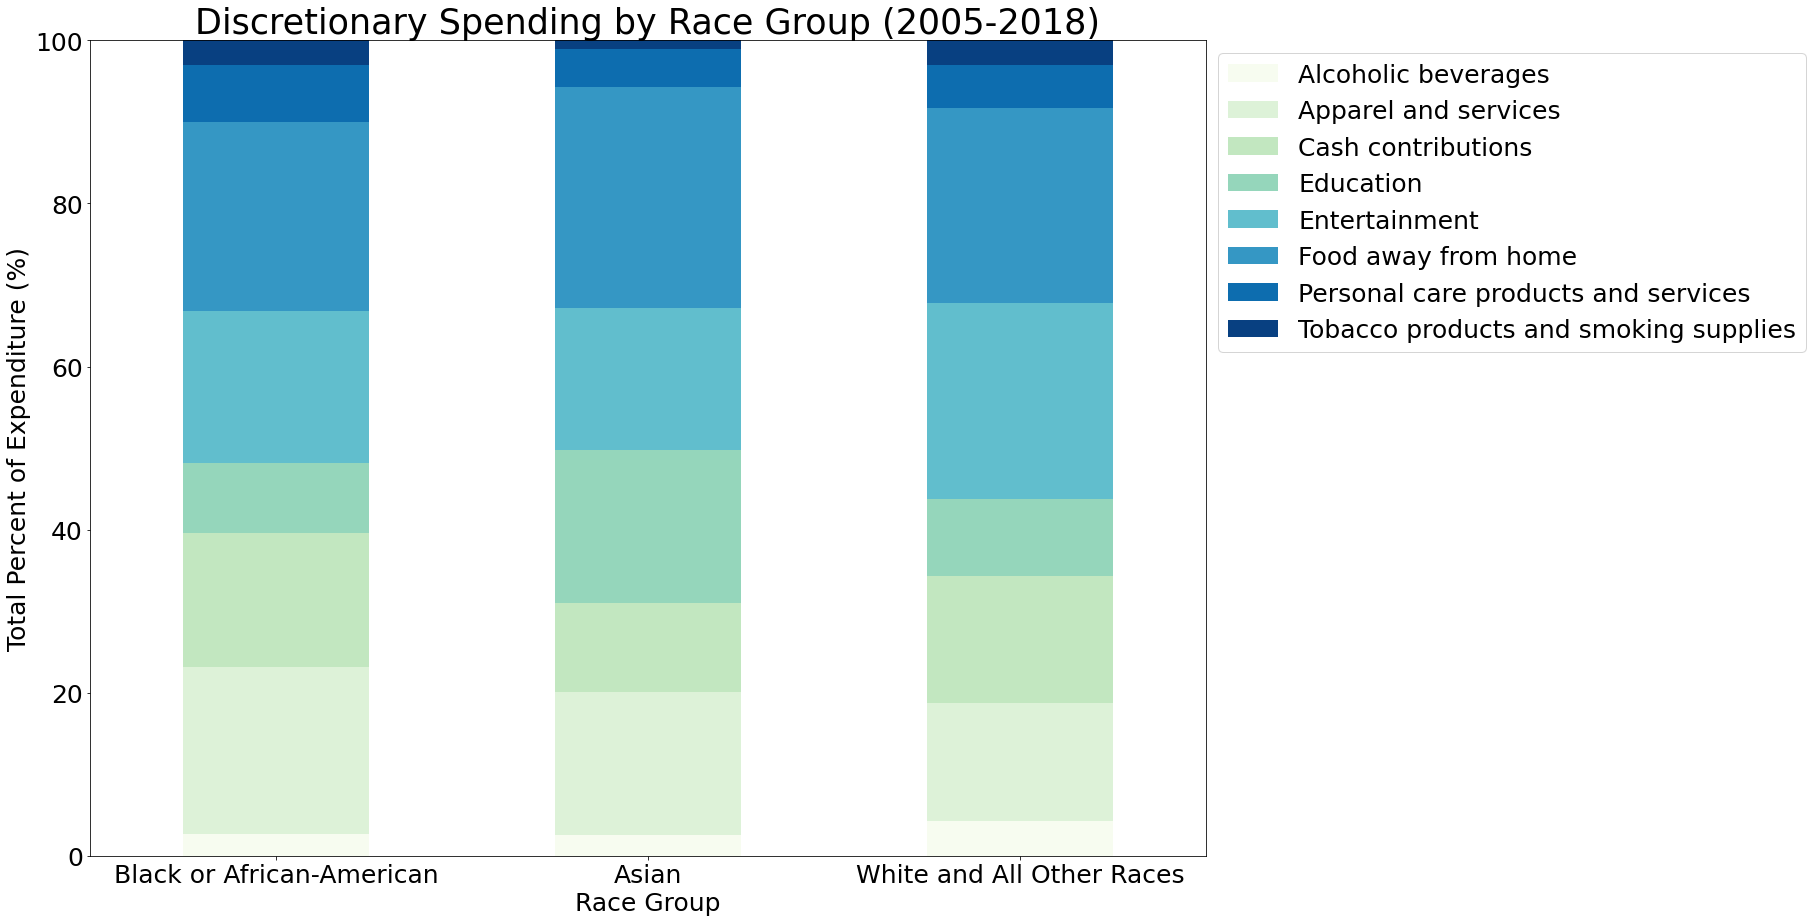

In [23]:
# Create stacked bar chart

# Compute the percentage 
race_df = race_df.div(race_df.sum(axis=1), axis=0) * 100

# Plot a stacked barchart
tocolor = (discretionary_labels)
colors = plt.get_cmap("GnBu", len(tocolor)) #CHANGE THIS TO EDIT COLORS. SEE CMAP COLOR FORMATS, https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
ax = race_df.plot.bar(stacked=True, figsize=(20,15), fontsize=25, colormap=colors)

# Place the legend
ax.legend(bbox_to_anchor=(1, 1), fontsize=25)
plt.xticks(rotation=0)
plt.ylim(0, 100) 
plt.title('Discretionary Spending by Race Group (2005-2018)', fontsize=35)
plt.xlabel('Race Group', fontsize=25)
plt.ylabel('Total Percent of Expenditure (%)', fontsize=25)

# Save figure
plt.savefig('Images/spend_by_race.png',bbox_inches="tight")
plt.show()

### Education Levels
Calling API Query to get discretionary spending based on education level demographics

In [24]:
# Education Breakdown 

# EDUCATION COMPLETED: LESS THAN HIGH SCHOOL LB1303M
nohighschool_dict = {

    'CXUFOODAWAYLB1303M': 'Less Than HS Food Away',
    'CXUAPPARELLB1303M': 'Less Than HS Apparel',
    'CXUENTRTAINLB1303M': 'Less Than HS Entertainment',
    'CXUCASHCONTLB1303M': 'Less Than HS Cash contribution',
    'CXUALCBEVGLB1303M': 'Less Than HS Alcoholic Beverages',
    'CXUEDUCATNLB1303M': 'Less Than HS Education',
    'CXUPERSCARELB1303M': 'Less Than HS Personal Care',
    'CXUTOBACCOLB1303M': 'Less Than HS Tobacco',
}
        
df_nohighschool = json_df(nohighschool_dict)

# EDUCATION COMPLETED: HIGH SCHOOL LB1304M
highschool_dict = {
    'CXUFOODAWAYLB1304M': 'High School Food Away',
    'CXUAPPARELLB1304M': 'High School Apparel',
    'CXUENTRTAINLB1304M': 'High School Entertainment',
    'CXUCASHCONTLB1304M': 'High School Cash Contribution',
    'CXUALCBEVGLB1304M': 'High School Alcoholic Beverages',
    'CXUEDUCATNLB1304M': 'High School Education',
    'CXUPERSCARELB1304M': 'High School Personal Care',
    'CXUTOBACCOLB1304M': 'High School Tobacco',
}
    

df_highschool = json_df(highschool_dict)

# EDUCATION COMPLETED: ASSOCIATE LB1306M
associate_dict = {
    'CXUFOODAWAYLB1306M': 'Associate Food Away',
    'CXUAPPARELLB1306M': 'Associate Apparel',
    'CXUENTRTAINLB1306M': 'Associate Entertainment',
    'CXUCASHCONTLB1306M': 'Associate Cash Contribution',
    'CXUALCBEVGLB1306M': 'Associate Alcoholic Beverages',
    'CXUEDUCATNLB1306M': 'Associate Education',
    'CXUPERSCARELB1306M': 'Associate Personal Care',
    'CXUTOBACCOLB1306M': 'Associate Tobacco',
}

df_associate = json_df(associate_dict)

# EDUCATION COMPLETED: BACHELORS LB1308M
bachelors_dict = {
    'CXUFOODAWAYLB1308M': 'Bacherlors Food Away',
    'CXUAPPARELLB1308M': 'Bacherlors Apparel',
    'CXUENTRTAINLB1308M': 'Bacherlors Entertainment',
    'CXUCASHCONTLB1308M': 'Bacherlors Cash Contribution',
    'CXUALCBEVGLB1308M': 'Bacherlors Alcoholic Beverages',
    'CXUEDUCATNLB1308M': 'Bacherlors Education',
    'CXUPERSCARELB1308M': 'Bacherlors Personal Care',
    'CXUTOBACCOLB1308M': 'Bacherlors Tobacco',
}

df_bachelors = json_df(bachelors_dict)

# EDUCATION COMPLETED: PROFESSIONAL, MASTER'S, DOCTORATE LB1309M
professional_dict = {
    'CXUFOODAWAYLB1309M': 'Professional Food Away',
    'CXUAPPARELLB1309M': 'Professional Apparel',
    'CXUENTRTAINLB1309M': 'Professional Entertainment',
    'CXUCASHCONTLB1309M': 'Professional Cash Contribution',
    'CXUALCBEVGLB1309M': 'Professional Alcoholic Beverages',
    'CXUEDUCATNLB1309M': 'Professional Education',
    'CXUPERSCARELB1309M': 'Professional Personal Care',
    'CXUTOBACCOLB1309M': 'Professional Tobacco',
}

df_professional = json_df(professional_dict)


In [25]:
#Set list for each Education value to store totals for each category (alphabetized)

#Grab Values for Education Levels
Nohs = get_total(df_nohighschool)
Highschool = get_total(df_highschool)
Associate = get_total(df_associate)
Bachelor = get_total(df_bachelors)
Professional = get_total(df_professional)

edu_totals = [Nohs, Highschool, Associate, Bachelor, Professional]

# EDUCATION DF
edu_name=['< High School', 'High School', 'Associate', 'Bachelor', 'Professional']
edu_df = pd.DataFrame(data=edu_totals,
                      columns=discretionary_labels)
edu_df["Education Completed"] = edu_name
edu_df.set_index("Education Completed", drop=True, inplace=True)
edu_df

,Alcoholic beverages,Apparel and services,Cash contributions,Education,Entertainment,Food away from home,Personal care products and services,Tobacco products and smoking supplies
Education Completed,,,,,,,,
< High School,1218,9031,5590,1328,8943,10110,2425,2860
High School,2161,9503,8313,2840,13764,14220,3273,3344
Associate,3228,13088,11410,6623,19908,20054,4607,2462
Bachelor,4880,16721,18157,12683,24898,24860,5706,1328
Professional,5230,18155,26501,17103,29988,28388,6611,812


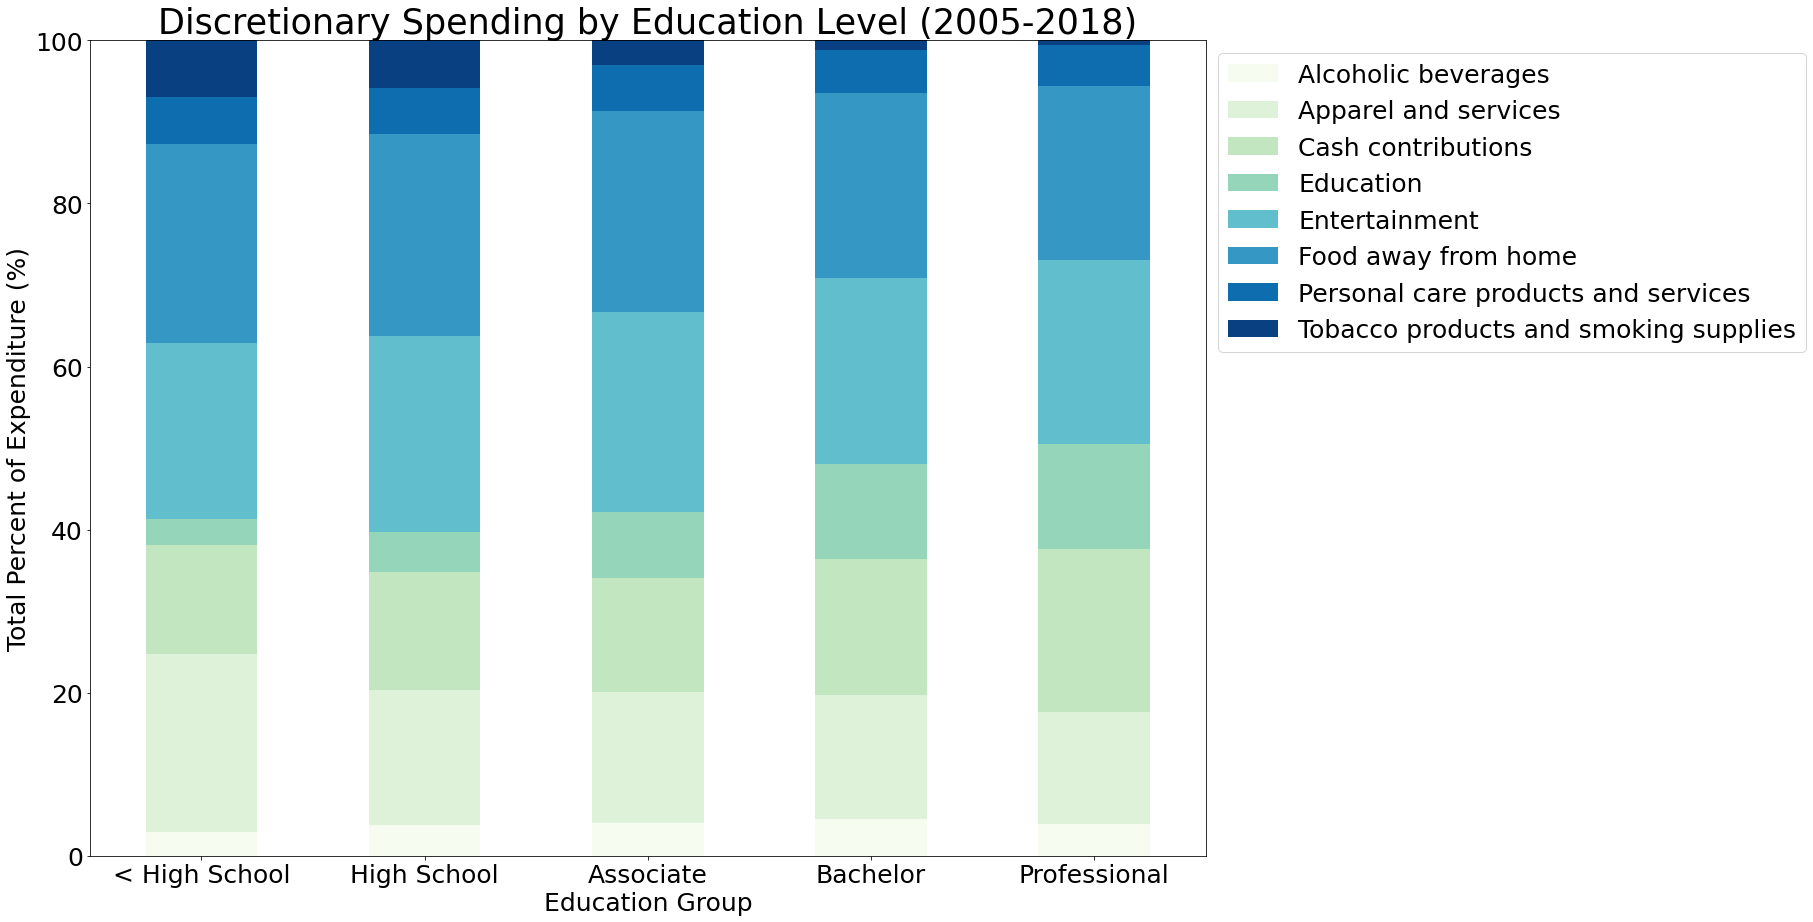

In [26]:
# Create stacked bar chart

# Compute the percentage 
edu_df = edu_df.div(edu_df.sum(axis=1), axis=0) * 100

# Plot a stacked barchart
tocolor = (discretionary_labels)
colors = plt.get_cmap("GnBu", len(tocolor)) #CHANGE THIS TO EDIT COLORS. SEE CMAP COLOR FORMATS, https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
ax = edu_df.plot.bar(stacked=True, figsize=(20,15), fontsize=25, colormap=colors)

# Place the legend
ax.legend(bbox_to_anchor=(1, 1), fontsize=25)
plt.xticks(rotation=0)
plt.ylim(0, 100) 
plt.title('Discretionary Spending by Education Level (2005-2018)', fontsize=35)
plt.xlabel('Education Group', fontsize=25)
plt.ylabel('Total Percent of Expenditure (%)', fontsize=25)

#Save figures
plt.savefig('Images/spend_by_education.png',bbox_inches="tight")
plt.show()